# Passive radar from our device

利用proc_4_V_auto里面的方法，处理我们自己的设备收集的数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import scipy.signal as signal
from PIL import Image
from tqdm import tqdm
from numba import jit
import pyfftw
import multiprocessing
nthread = multiprocessing.cpu_count()

# Read samples and transfer to complex iq datasets

In [2]:
# read the raw iq data
# capture with 'rtl_sdr -f 545000000 -d 0 -g 40 -s 2048000 -n 20480000 rtl3_F.dat'
# rtl_sdr -f 762000000 -d 0 -g 40 -s 2048000 -n 40960000 rtl3_F3.dat 
b4filename = 'dat.bin'
Fs = 2.4e6
F0 = 772e6

#Open the file in binary read mode    
with open(b4filename, "rb") as f:
    data = np.fromfile(f, dtype='int8')

In [3]:
# Turn the interleaved I and Q samples into complex values
# the syntax "dat[0::2]" means "every 2nd value in 
# array dat starting from the 0th until the end"
iq_dat = 1.0*data[0::2] + 1j*data[1::2]
NSAMP = len(iq_dat)

# generate time coordinates
dt = 1.0/Fs
tim = np.arange(0, dt*NSAMP, dt)

Now we have three parameters:

1. Fs    : sample rate
2. F0    : center frequency
3. NSAMP : number of samples 

# Plot the raw data

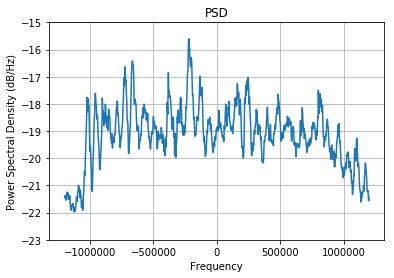

In [4]:
FFTLEN = 1024*1024
FFTSTAT = 0*1024
# PSD of the whole dataset
plt.psd(iq_dat[FFTSTAT:FFTSTAT+FFTLEN], NFFT=1024, Fs=int(Fs))
plt.title("PSD")
plt.show() 

Two additional parameters:

1. FFTLEN  : length of the samples in each coherent time
2. FFTSTAT : starting point of the samples for each coherent time

# Ambiguity function: straightforward way

We need more paramters to produce the range-dopple plot

1. Vmax       :   maximum speed (Vmin decide by F0/Fs and FFTLEN)
2. Rmax       :   maximum range (Rmin decided by Fs)

In [5]:
# doppler space
Vmax = 400                          # maximum speed required (km/h)
#Vmax = 100
Vmin = 3e8/(F0/Fs)*3.6/FFTLEN       # speed resolution (km/h)
Ndop = int(Vmax/Vmin)               # number of points in dopple space
Ddop = Fs/FFTLEN                    # frequency resolution in dopple space
Mdop = Ddop*Ndop                    # maximum frequency in dopple space
dop = np.arange(-Mdop, Mdop, Ddop)  # dopple space 

In [7]:
# range space
Rmax = 59                           # maximum range
#Rmax = 20
Rmin = (3e8/Fs)/1000                # range resolution (km)
Nrng = int(Rmax/Rmin)               # number of points in range space, must be even
tau  = np.arange(-Rmax, Rmax, Rmin) # range space

In [8]:
Nrng  # just make sure Nrng is even

472

In [9]:
# # the most straightforward way to calculate the ambiguity function, it is rather slow
# def amb_self(sig, tim):
#     """This function calculate the (self) ambiguity function from the signal 'sig' """
#     nn = len(sig)  # length of the signal 
#     amb = np.zeros((Nrng, 2*Ndop), dtype = complex)
#     for im in range(2*Ndop):
#         mes_sig = sig*np.exp( 2.0*1j*np.pi*tim*dop[im] )
#         tmp_amb = signal.correlate(sig, mes_sig, mode='same')           # use raw scipy correlate
#         amb[:, im] = tmp_amb[(nn//2-Nrng//2):(nn//2+Nrng//2)]/float(nn)
#     return amb

In [10]:
# # check a specific case
# FFTSTAT = 100*1024
# sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
# tim1 = tim[FFTSTAT:FFTSTAT+FFTLEN]
# %time aamm = amb_self(sig1, tim1)
# # create mesh grid for ambiguity function
# X, Y = np.meshgrid(dop, tau)
# am = np.abs(aamm)
# Z = am

In [11]:
# # find a proper range for imshow : Nfloor
# Nfloor = Nrng//2
# plt.imshow(am[0:Nfloor, :], interpolation='none', aspect='auto', extent=[-Mdop, Mdop, Rmin, Nfloor*Rmin])

In [12]:
# # We can plot the data in range-velocity space
# plt.imshow(am[0:Nfloor, :], interpolation='nearest', cmap='gray', aspect='auto', extent=[-Vmax, Vmax, Rmin, Nfloor*Rmin])

# Ambiguity function calculation in Frequency domain

In [13]:
# fftw version
def amb_self_fftw(sig):
    """This function calculate the (self) ambiguity function from the signal 'sig' """
    # first perform the fft for the signal: sig
    nn = len(sig)
    sig_fftw = pyfftw.interfaces.numpy_fft.fft(sig)
    
    # perform the 2d fft via fftw
    a = pyfftw.empty_aligned((2*Ndop, nn), dtype='complex')
    b = pyfftw.empty_aligned((2*Ndop, nn), dtype='complex')    
    # Plan an fft over the last axis
    #ifft_object_a = pyfftw.FFTW(a, b, direction='FFTW_BACKWARD', flags=('FFTW_MEASURE', ), threads=nthread, planning_timelimit=None)
    ifft_object_a = pyfftw.FFTW(a, b, direction='FFTW_BACKWARD', flags=('FFTW_MEASURE', ), threads=nthread, planning_timelimit=None)
    # generate the 2d array contains doppler shift information
    for im in range(2*Ndop):
        a[im, :] = np.roll(sig_fftw, im-Ndop)*np.conj(sig_fftw)
    ifft_object_a()
    
    # extract the range-doppler information
    amb = np.zeros((Nrng, 2*Ndop), dtype = complex)
    for im in range(2*Ndop):
        amb[:, im] = b[im, 0:Nrng]        
    return amb

In [22]:
# check a specific case
FFTSTAT = 100*1024
sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
%time aamm = amb_self_fftw(sig1)  # check the running time
# create mesh grid for ambiguity function
#X, Y = np.meshgrid(dop, tau)
am = np.log( np.abs(aamm) )
#am = np.abs(aamm)
Z = am

CPU times: user 12.1 s, sys: 620 ms, total: 12.7 s
Wall time: 5.65 s


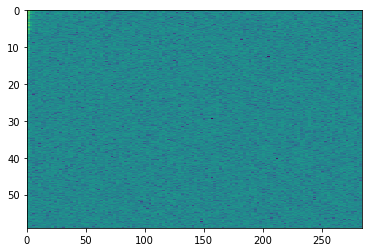

In [28]:
# find a proper range for imshow : Nfloor
Nfloor = 0
#plt.imshow(am[Nfloor:, :], interpolation='none', aspect='auto', extent=[-Mdop, Mdop, Rmax, Nfloor*Rmin])
plt.imshow(am[Nfloor:, Ndop:], interpolation='none', aspect='auto', extent=[0, Mdop, Rmax, Nfloor*Rmin])

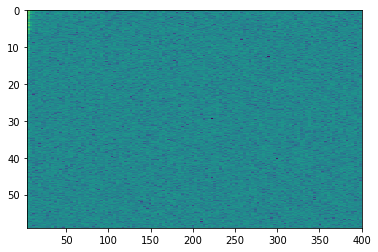

In [29]:
# Check the data in range-velocity space
#plt.imshow(am[Nfloor:, :], interpolation='nearest', aspect='auto', extent=[-Vmax, Vmin, Rmax, Nfloor*Rmin])
plt.imshow(am[Nfloor:, Ndop:], interpolation='nearest', aspect='auto', extent=[Vmin, Vmax, Rmax, Nfloor*Rmin])

# Create range-dopple plot with ambiguity function

In [30]:
# create gif figure
NT = int(NSAMP/FFTLEN)
snapshots = []
for nt in tqdm(range(NT)):
    FFTSTAT = nt*FFTLEN
    sig1 = iq_dat[FFTSTAT:FFTSTAT+FFTLEN]
    aamm = amb_self_fftw(sig1)
    am = np.log( np.abs(aamm) )
    #am = np.abs(aamm)
    snapshots.append(am)
    #print(nt)

100%|██████████| 39/39 [03:55<00:00,  6.04s/it]


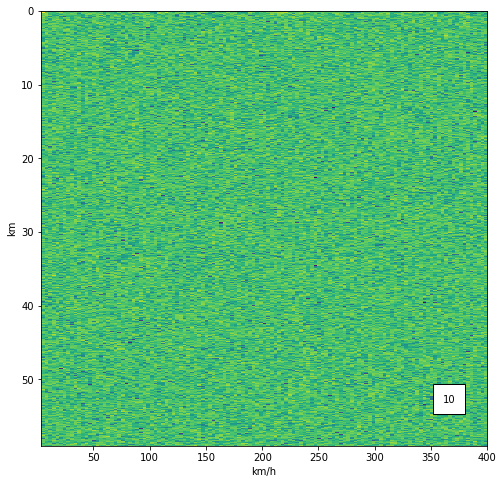

In [31]:
# a test shot gif
a = snapshots[10][Nfloor:, Ndop+1:]
fig = plt.figure( figsize=(8,8) )
plt.xlabel("km/h")
plt.ylabel("km")
text_it = 10
plt.text(Vmax-(Ndop/10)*Vmin, Rmax-(Nrng/10)*Rmin, text_it, bbox={'facecolor': 'white', 'pad': 10})
plt.imshow(a, interpolation='nearest', aspect='auto', extent=[Vmin, Vmax, Rmax, Nfloor*Rmin])

Now let us make gif

....................Done!
.

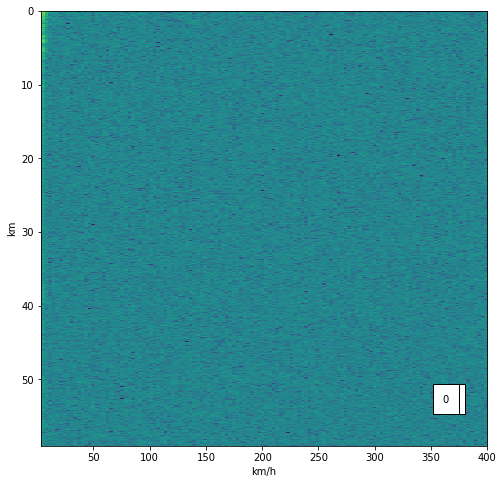

In [32]:
fps = 2
nSeconds = NT//fps

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )
plt.xlabel("km/h")
plt.ylabel("km")

#a = snapshots[0][Nfloor:, :]
a = snapshots[0][Nfloor:, Ndop:]

#im = plt.imshow(a, interpolation='nearest', aspect='auto', extent=[-Vmax, Vmax, Rmax, Nfloor*Rmin])
im = plt.imshow(a, interpolation='nearest', aspect='auto', extent=[Vmin, Vmax, Rmax, Nfloor*Rmin])

text_it = 0
plt.text(Vmax-(Ndop/10)*Vmin, Rmax-(Nrng/10)*Rmin, text_it, bbox={'facecolor': 'white', 'pad': 10})

def animate_func(i):
    #print(i)
    if i % fps == 0:
        print( '.', end ='' )
    text_it = i
    plt.text(Vmax-(Ndop/10)*Vmin, Rmax-(Nrng/10)*Rmin, text_it, bbox={'facecolor': 'white', 'pad': 10})
    #im.set_array(snapshots[i][Nfloor:, :])
    im.set_array(snapshots[i][Nfloor:, Ndop:])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('passive_radar.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')

# plt.show()  # Not required, it seems!